In [345]:
import os
import re
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from konlpy.tag import Okt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 데이터 전처리 및 사전 생성

In [346]:
# 데이터 import
def import_data(data_name):
    imported_data = 0
    data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'+data_name
    imported_data = pd.read_csv(data_path)
    return imported_data


# 불용어 제거를 위한 함수
def cleaning_sentence(sentence):
        sentence = sentence.lower()
        sentence = BeautifulSoup(sentence, "lxml").text
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'\([^)]*\)', '', sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub("[^가-힣a-zA-Z0-9\.\?\!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence


# 불용어 제거
def preprocess_sentence(data_list):
    retrun_list = []
    
    if isinstance(data_list, list):
        for sentence_frame in data_list:
            single_list = []
            for sentence in sentence_frame:
                cleaned_sentence = cleaning_sentence(sentence)
                single_list.append(cleaned_sentence)
            retrun_list.append(single_list)
    else:
        cleaned_sentence = cleaning_sentence(data_list)
        retrun_list = cleaned_sentence
        
    return retrun_list


# 토크나이저 기반 단어장 생성
def make_voca(data_list):
    questions = data_list[0]
    answers = data_list[1]
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
    START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
    st_token = [START_TOKEN, END_TOKEN]
    return tokenizer, st_token


# 생성된 단어장 기반으로 문장 토큰화
def tokenizer_encoding(data_list, tokenizer, st_token):
    encoding_data = []
    for sentence_list in data_list:
        encoding_sentence = []
        for sentence in sentence_list:
            a_sentence = st_token[0] + tokenizer.encode(sentence) + st_token[1]
            encoding_sentence.append(a_sentence)
        encoding_data.append(encoding_sentence)
        
    encoded_data = {'question' : encoding_data[0], 'answer' : encoding_data[1]}
    
    return encoded_data


# 문장 적정 길이 계산을 위한 함수
def visual_len(data_dic, q_rato, a_rato):
    question_len = [len(s) for s in data_dic['question']]
    answer_len = [len(s) for s in data_dic['answer']]
    print('question len. max :', np.max(question_len), ', min :', np.min(question_len), ', aver :', np.mean(question_len), ', var :', np.var(question_len))
    print('answer len. max :', np.max(answer_len), ', min :', np.min(answer_len), ', aver :', np.mean(answer_len), ', var :', np.var(answer_len))
    
    question_len = sorted(question_len)
    q_rato_index = int(len(question_len)*q_rato)
    answer_len = sorted(answer_len)
    a_rato_index = int(len(answer_len)*a_rato)
    print('your question rate set as : ', question_len[q_rato_index])
    print('your answer rate set as : ', answer_len[a_rato_index])
    return


# 문장 길이 정규화 및 패딩
def take_padding(data_dic, max_len):
    return_dic = {}
    cutten_dic = {}
    
    for name in ['question', 'answer']:
        single_cutten_list = []
        for single_list in data_dic[name]:
            if len(single_list) > max_len :
                return_list = 'del'
            else :
                return_list = single_list
            single_cutten_list.append(return_list)
        cutten_dic[name] = single_cutten_list
        
    cutten_df = pd.DataFrame.from_dict(cutten_dic)
    cutten_df.replace('del', np.nan, inplace=True)
    cutten_df.dropna(axis=0, inplace=True)
    return_dic = cutten_df.to_dict('list')
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(return_dic['question'], maxlen=max_len, padding='post')
    outputs = tf.keras.preprocessing.sequence.pad_sequences(return_dic['answer'], maxlen=max_len, padding='post')
    return [inputs, outputs], max_len

## 모델 구축에 관련한 함수

In [139]:
# 어텐션 점곱 계산 식
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output


# 패딩 마스크 생성을 위한 함수 (패딩된 부분을 1로 표시한)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


# 룩 어헤드 마스크 생성을 위한 함수 (디코더 셀프 마스크 어텐션시)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


# loss 및 metric 함수
def loss_function(y_true, y_pred, max_len = max_len):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred, max_len = max_len):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# 교사 강요를 위한 데이터셋을 제작하는 함수
def teacher_extortion(data_list, BATCH_SIZE, BUFFER_SIZE):
    question = data_list[0]
    answer = data_list[1]
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': question,
            'dec_inputs': answer[:, :-1]
        },
        {
            'outputs': answer[:, 1:]
        },
    ))
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

## 포지셔널 인코딩

In [118]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## 멀티 헤드 어텐션

In [119]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value =  self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        return outputs

## 커스텀 learning rate

In [120]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## 인코더 레이어 구축

In [121]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
        return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더 레이어 구축

In [122]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
        return tf.keras.Model(
            inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
            outputs=outputs,
            name=name)

## 트랜스포머 전체 모델 구축

In [123]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 인퍼런스 모델 구축

In [327]:
def decoder_inference(sentence, tokenizer, st_token, max_len, top_k):
    START_TOKEN = st_token[0]
    END_TOKEN = st_token[1]
    
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(max_len):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        if top_k > 0:
            predictions = tf.squeeze(predictions, axis=1)
            top_k_values, top_k_indices = tf.nn.top_k(predictions, k=top_k)
            top_k_probabilities = tf.nn.softmax(top_k_values)
            sampled_index = tf.random.categorical(tf.math.log(top_k_probabilities), num_samples=1)
            predicted_id = tf.gather(top_k_indices[0], sampled_index[0][0])
        else:
            predicted_id = tf.argmax(predictions, axis=-1)
            predicted_id = predicted_id[0][0]
                
        predicted_id = tf.cast(predicted_id, tf.int32)
        predicted_id = tf.expand_dims(predicted_id, axis=0)
        
        if tf.equal(predicted_id, END_TOKEN):
            break
        
        predicted_id = tf.expand_dims(predicted_id, axis=0)
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence,  tokenizer, st_token, max_len, temperature=0.1):
    prediction = decoder_inference(sentence,  tokenizer, st_token, max_len, temperature)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

# 데이터기반 학습-예측

## ChatbotData

### 데이터 import

In [318]:
data = import_data('ChatbotData .csv')
data_list = [data['Q'], data['A']]

### 데이터 전처리 (정규화, 토큰화, 인코딩, 패딩, 교사 강요)

In [319]:
preprocessed_data_list = preprocess_sentence(data_list)

tokenizer, st_token = make_voca(preprocessed_data_list)

encoded_data = tokenizer_encoding(preprocessed_data_list, tokenizer, st_token)

In [320]:
visual_len(encoded_data, 0.8, 0.8)

question len. max : 23 , min : 3 , aver : 7.484986889960247 , var : 6.268889890295859
answer len. max : 31 , min : 3 , aver : 7.818404804195213 , var : 6.775701185368106
your question rate set as :  9
your answer rate set as :  10


In [321]:
padding_data, max_len = take_padding(encoded_data, 10)

dataset = teacher_extortion(padding_data, 64, 20000)

### 모델 구축

In [322]:
tf.keras.backend.clear_session()

VOCAB_SIZE = tokenizer.vocab_size + 2
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

In [323]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2617088     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [324]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [325]:
model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
143/143 [==============================] - 6s 20ms/step - loss: 5.6765 - accuracy: 0.0830
Epoch 2/30
143/143 [==============================] - 3s 19ms/step - loss: 4.7528 - accuracy: 0.2109
Epoch 3/30
143/143 [==============================] - 3s 19ms/step - loss: 3.9283 - accuracy: 0.2152
Epoch 4/30
143/143 [==============================] - 3s 19ms/step - loss: 3.4922 - accuracy: 0.2206
Epoch 5/30
143/143 [==============================] - 3s 19ms/step - loss: 3.2514 - accuracy: 0.2314
Epoch 6/30
143/143 [==============================] - 3s 19ms/step - loss: 3.0457 - accuracy: 0.2441
Epoch 7/30
143/143 [==============================] - 3s 19ms/step - loss: 2.8401 - accuracy: 0.2635
Epoch 8/30
143/143 [==============================] - 3s 19ms/step - loss: 2.6119 - accuracy: 0.2910
Epoch 9/30
143/143 [==============================] - 3s 19ms/step - loss: 2.3555 - accuracy: 0.3215
Epoch 10/30
143/143 [==============================] - 3s 19ms/step - loss: 2.0766 - accura

### 추론 모델 구동

In [328]:
sentence_generation("반가워",  tokenizer, st_token, max_len, 3)

입력 : 반가워
출력 : 반갑습니다 .


'반갑습니다 .'

In [329]:
sentence_generation("오늘 기분은 어때?",  tokenizer, st_token, max_len, 0)

입력 : 오늘 기분은 어때?
출력 : 숨 쉴만 했으면 좋겠네요 .


'숨 쉴만 했으면 좋겠네요 .'

In [330]:
sentence_generation("행복한 하루 보내",  tokenizer, st_token, max_len, 1)

입력 : 행복한 하루 보내
출력 : 매일매일 행복한 일이 생기죠


'매일매일 행복한 일이 생기죠'

In [331]:
sentence_generation("데카르트가 정의한 행복은 뭘까?",  tokenizer, st_token, max_len, 1)

입력 : 데카르트가 정의한 행복은 뭘까?
출력 : 너무 무리하지는 마세요 .


'너무 무리하지는 마세요 .'

In [332]:
sentence_generation("소크라테스가 정의한 행복은 뭘까?",  tokenizer, st_token, max_len, 1)

입력 : 소크라테스가 정의한 행복은 뭘까?
출력 : 우선 꾸준히 연락하고 잘해줘보세요 .


'우선 꾸준히 연락하고 잘해줘보세요 .'

### 디버그 사항
- 아래 사진과 같은 문제가 발생하였으며, 단어 중복을 피하귀 위해 softmax temperature를 조절해보았음
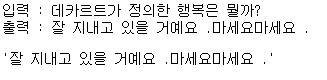

- 마침표가 나오는 경우 end_token으로 연결되지 않는 문제가 있는 것으로 확인됨
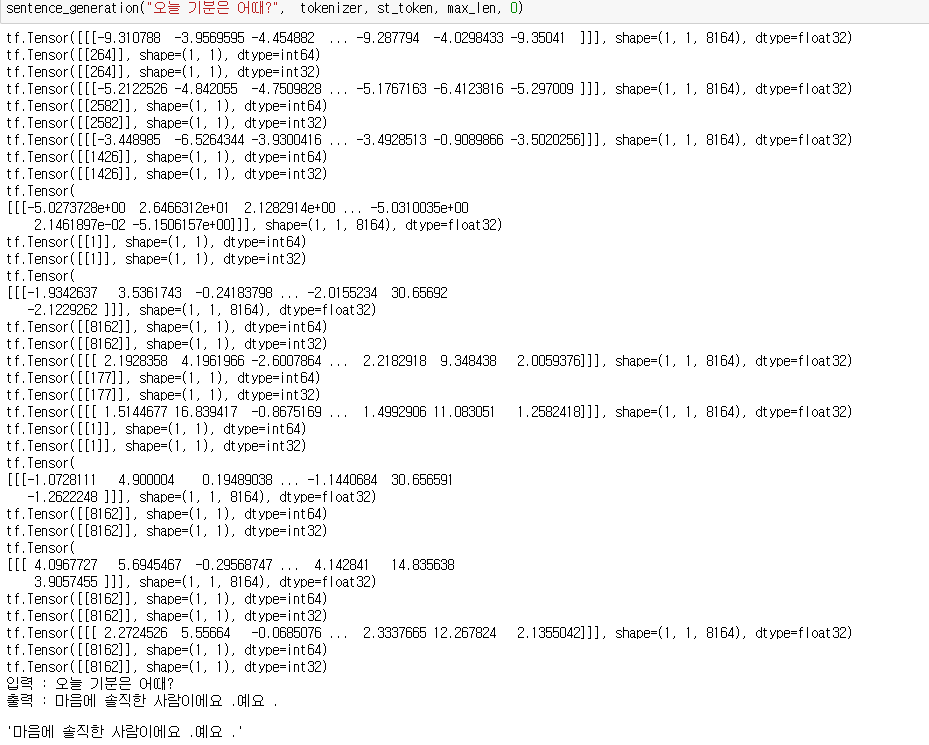

- 차원 문제 때문에 (predicted_id의 경우 3D 텐서) 중단이 안되는 것으로 판단하여, 해당사항을 수정함
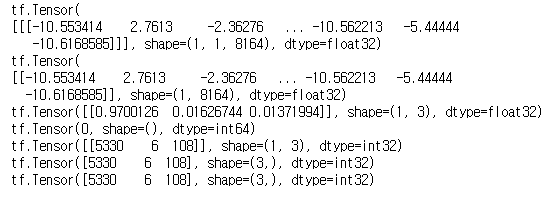

- (수정정 코드)
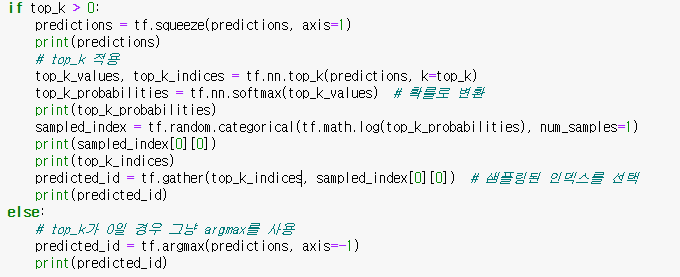
- (수정된 코드)
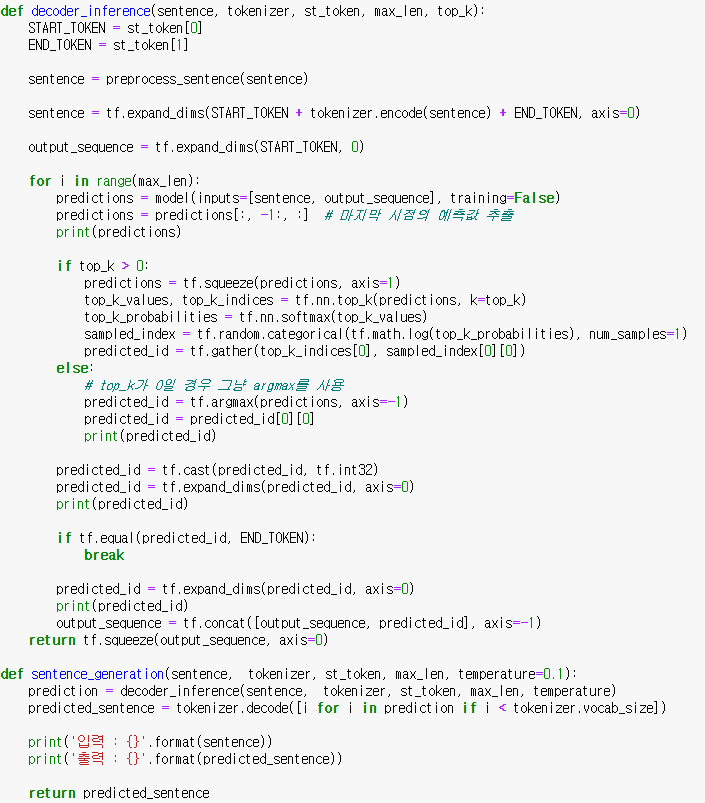

- 수정하였음에도 반복되어 확인하여 보니, 8162 인덱스가 말미에 반복되는 것으로 확인함
- 아래 코드가 문제인 것으로 확인함.. (뒤에 있는 st_token[0] -> st_token[1]이어야함)
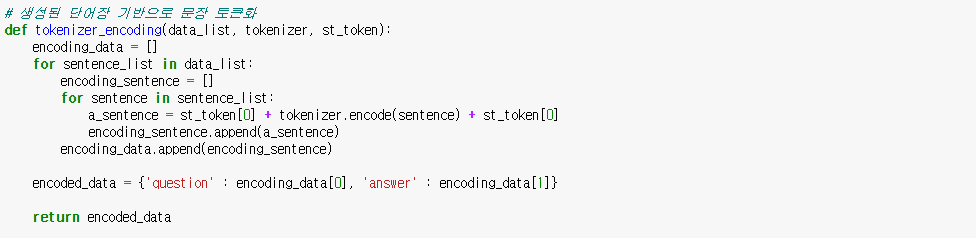

- 수정이후 정상적으로 나오는 것을 확인
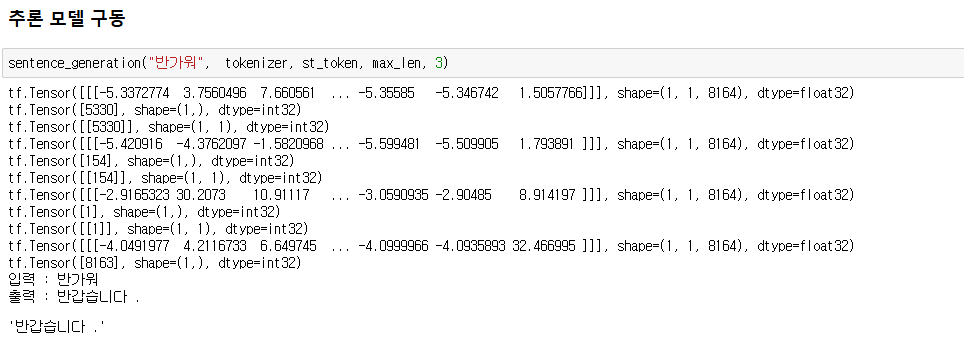

# 회고

- 효율성 고려
    - 중간에 디버깅에 너무 많은 시간을 소요하였음
    - 형태소 분석기 등 다양한 토크나이저를 사용할 시 새로 함수를 작성해야함
    - 전반적으로 함수의 범용성이 없으며, 각 함수마다 들어가는 인자가 너무 많음
    - 전처리 과정에서 문장을 자세하게 분석하지 않았음 --> 동사 변형마다 다른 토큰이 생김
    - 빈도가 높지 않은 특수 단어를 제거하지 않았음
    - 패딩 시 길이를 너무 짧게 준 부분이 있음

- 추가 실험 고려
    - 주어진 데이터가 아닌 다양한 데이터에서도 구동 필요
    - 특히 규모가 큰 데이터를 이용해볼 필요가 있음
        (본 데이터의 경우 규모가 적어 학습이 지나치게 빠르고, 다양한 대답 혹은 문장이 길어지면 대답을 잘 못함)
    - 형태소 분석기 등 전처리에 대한 부분을 더 깊게 고민해 볼 필요가 있음
    - BLEU/ROGUE score 등 다양한 평가지표를 사용해볼 필요가 있음

# 추가 실험

## 형태소 분석기 사용 (미완)

In [ ]:
def using_okt(data_list):
    okt = Okt()
    tokenizer = Tokenizer()
    okted_sentence = []
    for data in data_list

## 다른 데이터 셋 활용 (미완)

- 아래 데이터는 ai_hub(https://www.aihub.or.kr/)에서 제공받은 데이터이며, 질문과 응답으로 구성되어있음
- 다만 주어진 'context' 기반의 질의 응답이라, 구현 방법을 더 고민해보아야 할 것 같음
- 데이터 출처는 아래와 같음
- https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=89 (ai_hub, 한국어 기계독해 데이터)

In [342]:
data_path = os.getenv('HOME')+'/aiffel/ai_hub/data/'+'ko_nia_normal_squad_all.json'
with open(data_path) as f:
    js = json.loads(f.read())
korean_data = pd.DataFrame(js)

In [344]:
korean_data['data'][2]

{'title': '20180305114044000',
 'paragraphs': [{'context': '중국의 한 여성 경찰이 아파트에서 추락하던 3세 아이를 살리고 자신은 혼수상태에 빠졌습니다. 의인(義人)의 소식이 알려지자 각박한 중국 사회에 큰 반향을 일으키고 있습니다. 5일 귀주도시망 등 중국 현지 언론에 따르면 구이저우성 카일리시에 보조 교통 경찰로 일하는 천중핑(49)은 지난달 28일 한 아파트에서 비상 상황이 발생했다는 연락을 받고 현장으로 향했습니다. 도착했을 때 아파트 4층 창문에서 여자 아이가 매달려 있었습니다. 곧이어 아이는 손에 힘이 빠지면서 밑으로 추락했습니다. 천중핑과 다른 세명의 이웃들이 달려갔습니다. 그리고 아이는 바닥이 아니라 천중핑의 팔에 떨어졌습니다. 중간 비막이 천막 때문에 속도가 줄기는 했지만 추락의 충격은 천중핑이 고스란히 감당해야 했습니다. 아이는 즉시 병원으로 옮겨져 치료를 받았습니다. 다리 골절로 그리 심각한 상황은 아니라고 합니다. 하지만 생명의 은인이자 영웅은 커다란 댓가를 치러야 했다. 뇌출혈로 인한 의식불명 상태에 빠진 것이다. 다행히 이틀 간의 코마 상태 이후 의식을 회복해 지난 2일부터 중환자실에서 치료를 받고 있습니다. 아이는 열쇠공이 문을 따는 소리에 겁을 먹고 창문 밖으로 도망을 치려다 사고를 당한 것으로 전해졌습니다. 아이가 잠든 사이 돌보던 아이의 할머니가 쓰레기를 버리러 나갔다가 문이 잠기는 바람에 열쇠공을 불렀던 것입니다. 아이의 엄마는 “천중핑의 도움이 없었다면 아이는 죽었을 것”이라며 딸을 구해준 천중핑에게 감사의 뜻을 전했습다. 카일리시 정부 대표와 공안부 관계자들도 천중핑이 입원한 병원을 찾아 위로하고 회복될때까지 도움을 아끼지 않겠다고 밝혔습니다. 천중핑의 선행 사실을 접한 중국 기업 알리바바도 ‘중국의 좋은 이웃상’과 함께 상금 1만 위안(약 170만원)을 수여하기로 했습니다. [아직 살만한 세상]은 점점 각박해지는 세상에 희망과 믿음을 주는 이들의 이야기입니다. 힘들고 지칠 때